In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [19]:
# Download necessary NLTK data
# nltk.download('stopwords')

# Load the dataset
dataset = pd.read_csv('labeled_data.csv')

# Basic EDA
print(dataset.head())
print(dataset.info())
print(dataset.describe().T)


   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24

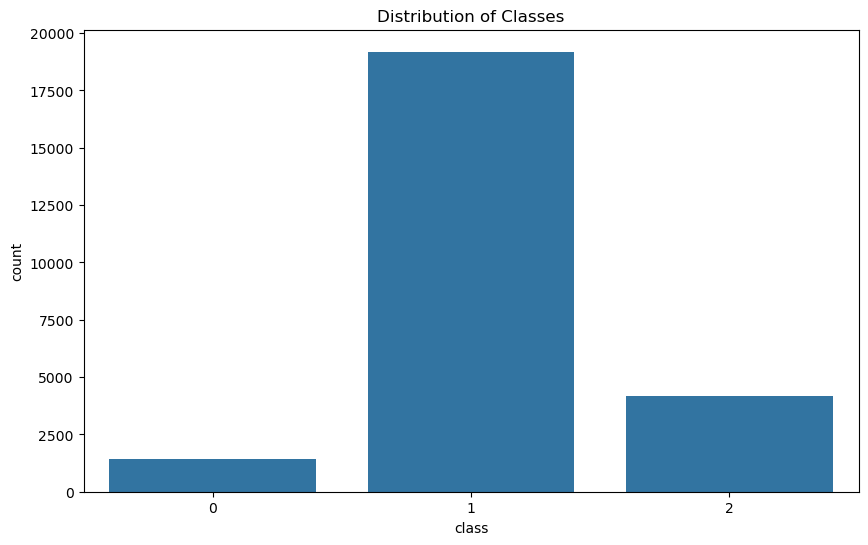

In [20]:
# EDA - Visualizations
plt.figure(figsize=(10, 6))
sns.countplot(x='class', data=dataset)
plt.title('Distribution of Classes')
plt.show()

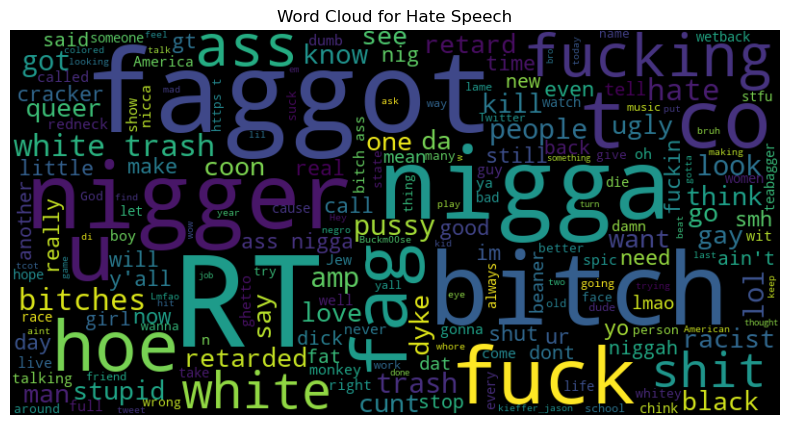

In [21]:
# Word Cloud for hate speech
hate_tweets = dataset[dataset['class'] == 0]['tweet']
wordcloud = WordCloud(width=800, height=400).generate(' '.join(hate_tweets))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Hate Speech')
plt.show()

In [22]:
# Data preprocessing
dt_transformed = dataset[['class', 'tweet']]
y = dt_transformed['class'].values
X = dt_transformed['tweet']

# Text cleaning
corpus = []
for tweet in X:
    review = re.sub('[^a-zA-Z]', ' ', tweet)
    review = review.lower().split()
    ps = PorterStemmer()
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    review = [ps.stem(word) for word in review if not word in set(all_stopwords)]
    review = ' '.join(review)
    corpus.append(review)

In [23]:
# Feature Extraction
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(corpus).toarray()

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# Model selection (using three models)
models = {
    'Random Forest': RandomForestClassifier(random_state=0),
    'Logistic Regression': LogisticRegression(random_state=0),
    'Decision Tree': DecisionTreeClassifier(random_state=0, criterion='entropy')
}


In [24]:
# Training and evaluating models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} - Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
    print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")


Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.14      0.21       279
           1       0.93      0.96      0.94      3852
           2       0.84      0.91      0.87       826

    accuracy                           0.90      4957
   macro avg       0.75      0.67      0.68      4957
weighted avg       0.89      0.90      0.89      4957

Confusion Matrix:
[[  38  213   28]
 [  39 3696  117]
 [   4   70  752]]
Accuracy Score: 0.9049828525317732

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.16      0.25       279
           1       0.92      0.97      0.94      3852
           2       0.85      0.84      0.85       826

    accuracy                           0.90      4957
   macro avg       0.77      0.66      0.68      4957
weighted avg       0.88      0.90      0.89      4957

Confusion Matrix:
[[  46  208   25]
 [  38 3

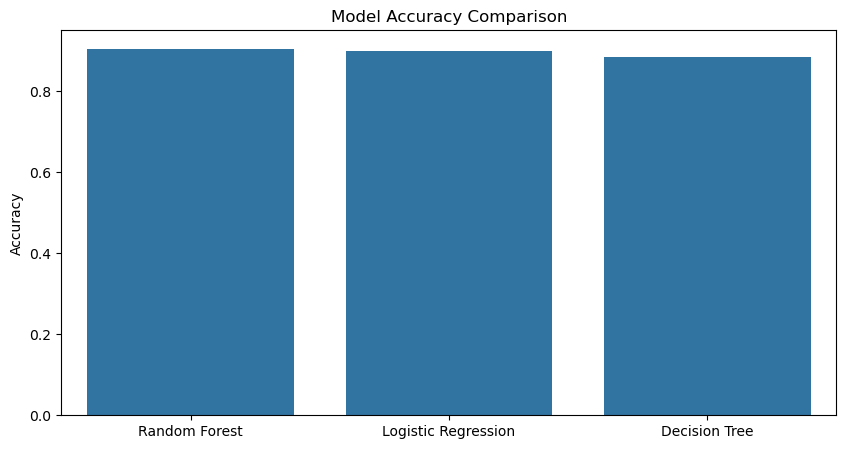

In [25]:
# Model Performance Comparison
accuracies = [accuracy_score(y_test, model.predict(X_test)) for model in models.values()]
plt.figure(figsize=(10, 5))
sns.barplot(x=list(models.keys()), y=accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()

In [26]:
# Basic optimization for Random Forest (example)
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=0), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\nBest parameters for Random Forest:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)


Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 100}
Best cross-validation score: 0.9031066206513243


In [27]:
# Evaluate the best model from GridSearch
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print("\nOptimized Random Forest - Classification Report:")
print(classification_report(y_test, y_pred_best))


Optimized Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.14      0.21       279
           1       0.93      0.96      0.94      3852
           2       0.84      0.91      0.87       826

    accuracy                           0.90      4957
   macro avg       0.75      0.67      0.68      4957
weighted avg       0.89      0.90      0.89      4957



In [29]:
# sample datas
test_tweets = [
    "bitch who do you love ",
    "Hello world, it is a beautiful day"
]

# Clean and vectorize the new tweets
test_corpus = []
for tweet in test_tweets:
    review = re.sub('[^a-zA-Z]', ' ', tweet)
    review = review.lower().split()
    ps = PorterStemmer()
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    review = [ps.stem(word) for word in review if not word in set(all_stopwords)]
    review = ' '.join(review)
    test_corpus.append(review)

X_new = vectorizer.transform(test_corpus).toarray()


In [33]:
# Predict using the optimized model
optimized_predictions = best_model.predict(X_new)
print("\nOptimized Model Predictions:")
for tweet, pred in zip(test_tweets, optimized_predictions):
    print(f"Tweet: {tweet} -> Predicted Class: {pred}")


Optimized Model Predictions:
Tweet: bitch who do you love  -> Predicted Class: 1
Tweet: Hello world, it is a beautiful day -> Predicted Class: 2
